In [15]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [46]:

# Gram-Schmidt orthogonalization function
def gram_schmidt(vectors):
    orthogonal = []
    for v in vectors:
        for u in orthogonal:
            v = v - np.dot(u, v) / np.dot(u, u) * u
        orthogonal.append(v)
    return np.array(orthogonal)

# Function to add noise while preserving covariance and higher moments
def add_noise_preserve_moments_multivariate(X, noise_level=0.01):
    """
    Add noise to multivariate financial data while preserving the first four moments
    and the covariance structure.
    
    X: np.array, original data (2D array where each column is a variable)
    noise_level: float, scaling factor for noise
    """
    # Step 1: Standardize the data to have mean 0 and variance 1
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    
    # Step 2: Compute the covariance matrix of the original standardized data
    cov_matrix = np.cov(X_std, rowvar=False)
    
    # Step 3: Generate noise and adjust it with Cholesky decomposition to match covariance structure
    noise = np.random.normal(0, 1, X_std.shape)
    L = np.linalg.cholesky(cov_matrix)  # Cholesky decomposition
    noise_cov_adjusted = noise @ L.T  # Adjust noise to preserve covariance structure
    
    # Step 4: Apply Gram-Schmidt orthogonalization to the noise to preserve higher-order moments
    combined_data = np.vstack([X_std.T, noise_cov_adjusted.T])  # Stacking rows (for orthogonalization)
    orthogonalized_noise = gram_schmidt(combined_data)[len(X_std.T):]  # Only keep orthogonalized noise part
    
    # Step 5: Add the orthogonalized noise to the original standardized data
    Y = X_std + orthogonalized_noise.T * noise_level
    
    # Step 6: Rescale the data back to its original scale
    Y_rescaled = scaler.inverse_transform(Y)
    
    # Adjust for both variance and covariance preservation
    Y_rescaled = correct_covariance(X, Y_rescaled)
    
    return Y_rescaled

# Function to adjust the covariance after noise is added
def correct_covariance(X, Y):
    """
    Correct both variance and covariance of the noisy data Y to match the original data X.
    
    X: np.array, original data (before adding noise)
    Y: np.array, noisy data (after adding noise)
    """
    # Compute the covariance matrices of X and Y
    cov_X = np.cov(X, rowvar=False)
    cov_Y = np.cov(Y, rowvar=False)
    
    # Whitening: Decorrelate Y by transforming it to have an identity covariance matrix
    cov_Y_inv_sqrt = np.linalg.inv(np.linalg.cholesky(cov_Y)).T  # Inverse Cholesky of cov_Y
    Y_whitened = (Y - np.mean(Y, axis=0)) @ cov_Y_inv_sqrt.T
    
    # Coloring: Apply the original covariance matrix of X to restore the correlation structure
    cov_X_sqrt = np.linalg.cholesky(cov_X)  # Cholesky of cov_X
    Y_colored = Y_whitened @ cov_X_sqrt.T + np.mean(X, axis=0)
    
    return Y_colored


# Example usage:
# np.random.seed(42)

# X_multivariate = np.random.multivariate_normal([0.05, 0.02], [[0.1, 0.01], [0.01, 0.1]], size=1000)
# Generate synthetic multivariate financial data (e.g., two asset returns)

# Add noise while preserving covariance structure and higher-order moments
# Y_multivariate = add_noise_preserve_moments_multivariate(X_multivariate, noise_level=1.0)

# # Checking moments before and after adding noise
# def print_moments(X, label):
#     print(f"\n{label} Moments:")
#     print(f"Mean: {np.mean(X, axis=0)}")
#     print(f"Variance: {np.var(X, axis=0)}")
#     print(f"Skewness: {stats.skew(X, axis=0)}")
#     print(f"Kurtosis: {stats.kurtosis(X, axis=0)}")
#     print(f"Covariance Matrix:\n{np.cov(X, rowvar=False)}\n")

# print_moments(X_multivariate, "Original Data")
# print_moments(Y_multivariate, "Noisy Data")


# x = pd.DataFrame(X_multivariate, columns= ['X1', 'X2'])
# y = pd.DataFrame(Y_multivariate, columns= ['Y1', 'Y2'])
# all_data = pd.concat([x, y], axis = 1)
# all_data.plot(alpha = 0.5)
# plt.show()

# (1 + all_data).cumprod().plot(alpha = 0.5)
# plt.show()

## real data

In [47]:
import pickle as pkl
with open('data_all.pkl','rb') as f:  #rb is read binary code
    cov_period, index_, returns = pkl.load(f)

# returns = returns[['EFA', 'EWJ', 'IWM', 'SPY', 'XLY']] #.iloc[:500] 
#basically convert all of returns to integer index
index_int=[x for x in range(len(returns.index))]

assets = ["AGG", "GLD", "LQD", "QQQ", "TIP", "VBR"]
returns = returns[assets]

In [48]:
X = returns.iloc[1:]


Original Data Moments:
Mean: [0.00011083 0.00033577 0.00014921 0.00055995 0.00013493 0.00043054]
Variance: [1.01258140e-05 1.26546875e-04 2.90823081e-05 1.87640218e-04
 1.56562043e-05 2.25647870e-04]
Skewness: [-2.51598091 -0.18518549  0.00546639 -0.17193715  0.20134783 -0.45542576]
Kurtosis: [68.29743977  6.29943168 69.02727119  7.42251681 10.77636227  9.05986408]

Noisy Data Moments:
Mean: [0.00011083 0.00033577 0.00014921 0.00055995 0.00013493 0.00043054]
Variance: [8.12714433e-06 1.03082628e-04 1.85215927e-05 1.09856626e-04
 1.26131390e-05 1.69929665e-04]
Skewness: [-0.16573866 -0.11740259 -0.10983591 -0.05500444 -0.13057401 -0.25341489]
Kurtosis: [10.45354558  4.06591779 29.01888996  1.9498199   8.80346106  7.0305194 ]


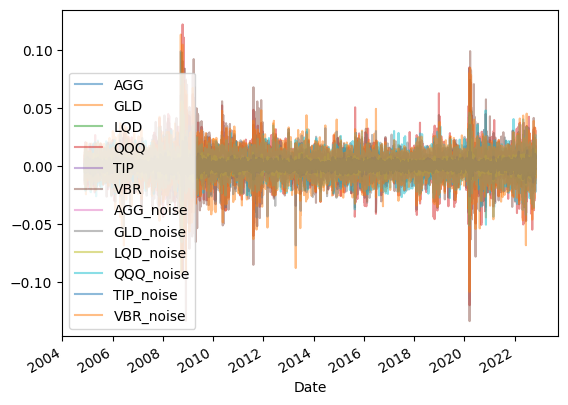

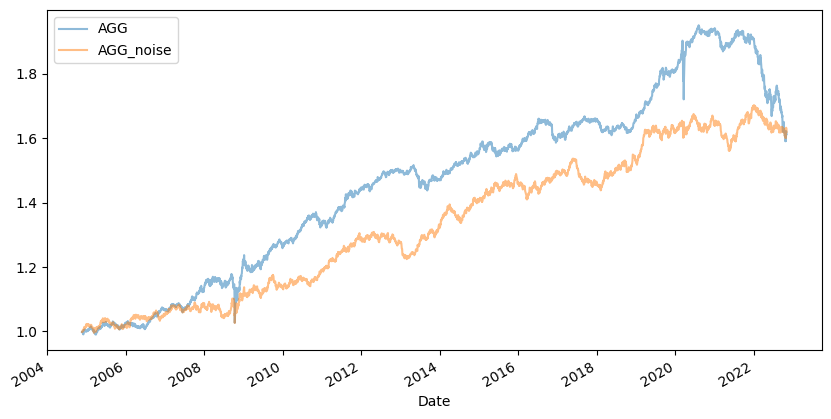

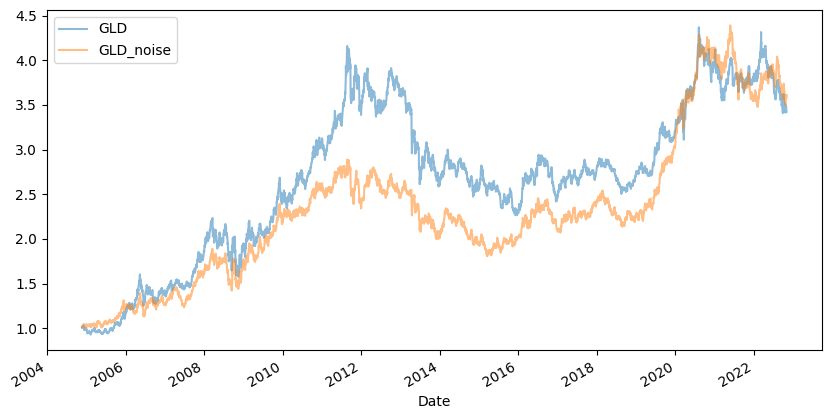

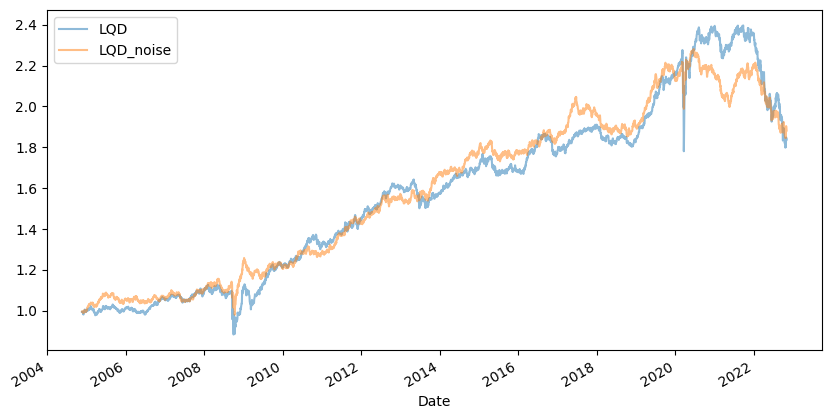

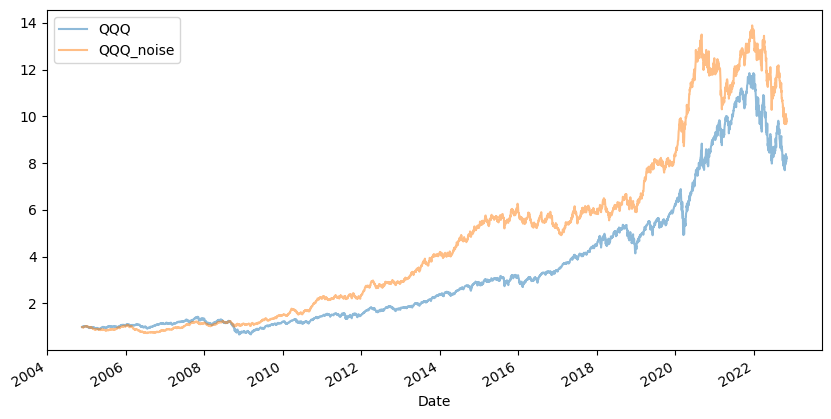

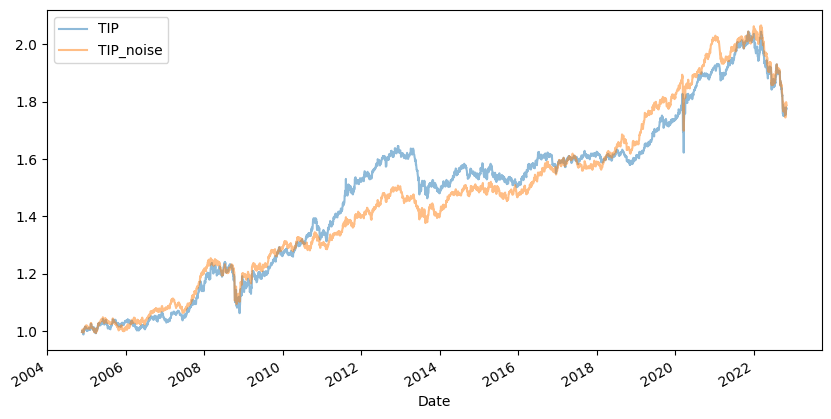

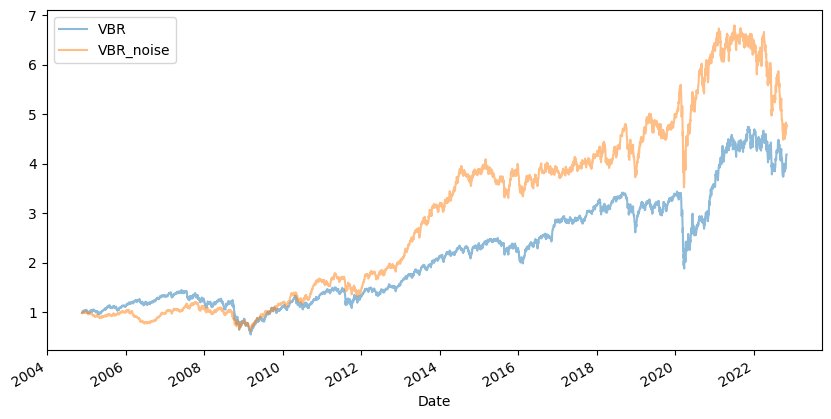

In [62]:
Y_multivariate = add_noise_preserve_moments_multivariate(X.to_numpy(), noise_level=1)
diffuse = 0.8
Y_multivariate = (1 - diffuse) * X.to_numpy() + diffuse * Y_multivariate
# Checking moments before and after adding noise
def print_moments(X, label):
    print(f"\n{label} Moments:")
    print(f"Mean: {np.mean(X, axis=0)}")
    print(f"Variance: {np.var(X, axis=0)}")
    print(f"Skewness: {stats.skew(X, axis=0)}")
    print(f"Kurtosis: {stats.kurtosis(X, axis=0)}")

print_moments(X.to_numpy(), "Original Data")
print_moments(Y_multivariate, "Noisy Data")


y = pd.DataFrame(Y_multivariate, columns = [ai + "_noise" for ai in assets], index = X.index)

all_data = pd.concat([X, y], axis = 1)
all_data.plot(alpha = 0.5)
plt.show()


ret_data = (1 + all_data).cumprod()

for ai in assets:
    ret_data[[ai, ai + "_noise"]].plot(alpha = 0.5, figsize=(10, 5))
    plt.show()

In [23]:
X.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\Toon\AppData\Local\Temp\ipykernel_15656\2694154310.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  X.corr().style.background_gradient(cmap='coolwarm').set_precision(2)


,AGG,GLD,LQD,QQQ,TIP,VBR
AGG,1.00,0.19,0.66,-0.04,0.64,-0.07
GLD,0.19,1.00,0.13,0.03,0.26,0.04
LQD,0.66,0.13,1.00,0.15,0.49,0.13
QQQ,-0.04,0.03,0.15,1.00,-0.14,0.80
TIP,0.64,0.26,0.49,-0.14,1.00,-0.13
VBR,-0.07,0.04,0.13,0.80,-0.13,1.00


In [63]:
y.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\Toon\AppData\Local\Temp\ipykernel_15656\2034640721.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  y.corr().style.background_gradient(cmap='coolwarm').set_precision(2)


,AGG_noise,GLD_noise,LQD_noise,QQQ_noise,TIP_noise,VBR_noise
AGG_noise,1.00,-0.09,0.47,0.09,0.48,0.14
GLD_noise,-0.09,1.00,-0.10,0.07,0.15,0.10
LQD_noise,0.47,-0.10,1.00,0.18,0.38,0.12
QQQ_noise,0.09,0.07,0.18,1.00,-0.00,0.71
TIP_noise,0.48,0.15,0.38,-0.00,1.00,0.13
VBR_noise,0.14,0.10,0.12,0.71,0.13,1.00
